In [61]:
import os
import seaborn as sns
import pandas as pd
from google.colab import drive
import numpy as np
from osgeo import gdal

In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!pip install -q xlrd

In [64]:
!pip install elevation

**Read Dataset into ds variable, then read this by numpy 2d array**

In [65]:
from __future__ import division
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import elevation

In [73]:
path_ = "/content/drive/My Drive/Knowledge/Data_Science_Prj/vnm_pd_2019_1km_UNadj.tif"

In [81]:
ds = gdal.Open(path_)
ds_band = ds.GetRasterBand(1)
nodataval = ds_band.GetNoDataValue()
ds_arr = ds.ReadAsArray().astype(np.float64)
print(ds_arr)

[[-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 ...
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]]


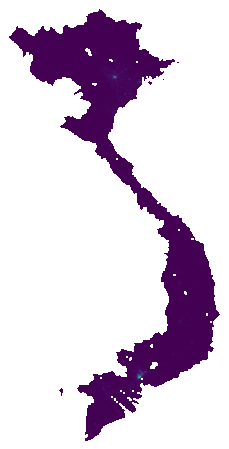

In [82]:
# replace missing values if necessary
if np.any(ds_arr == nodataval):
    ds_arr[ds_arr == nodataval] = np.nan

#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(ds_arr, cmap = "viridis")

In [83]:
prj = ds.GetProjection()
print(prj)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


In [93]:
def get_latlon(city_name):
    geolocator = Nominatim(user_agent="raster-extraction-tutorial")
    latlon = geolocator.geocode(city_name)
    return latlon

coords = get_latlon("Hanoi")
print(coords[1])

(21.0294498, 105.8544441)


In [85]:
def get_coords_at_point(path, pos):
    gdata = gdal.Open(path)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    row = int((pos[1] - gt[0])/gt[1])
    col = int((pos[0] - gt[3])/gt[5])
    return col, row

radius = 30
row, col = get_coords_at_point(path_, pos = coords[1]) 
circle = (row, col, radius)

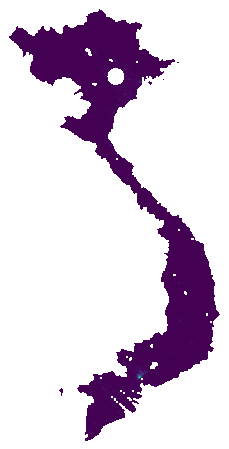

In [86]:
def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    
    def int_ceiling(x):
        return int(np.ceil(x))
    
    for i in range(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        
        for j in range(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
            arr[i][j] = np.nan
    
    return buffer_points

buffer_points = points_in_circle(circle, ds_arr)
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
plt.axis("off")
img = plt.imshow(ds_arr, cmap = "viridis")

In [87]:
mean = np.nanmean(buffer_points)
std = np.nanstd(buffer_points)
variance = np.nanvar(buffer_points)

print("Mean: %.2f" % mean)
print("Standard Deviation: %.2f" % std)
print("Variance: %.2f" % variance)

Mean: 3246.83
Standard Deviation: 5817.49
Variance: 33843213.32
